In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [26]:
import os
import numpy as np
import pandas as pd
from PIL import Image
import matplotlib.pyplot as plt
import math
import random

from fastai import vision, basic_data, layers, metrics

In [27]:
from fastai.basics import *
from fastai.vision import *
from fastai import vision, basic_data, layers, metrics

In [28]:
plt.style.use(['dark_background'])

### Getting the data

In [29]:
path = Config.data_path()/'competitions/airbus-ship-detection' 
path.ls()

[PosixPath('/home/jupyter/.fastai/data/competitions/airbus-ship-detection/models'),
 PosixPath('/home/jupyter/.fastai/data/competitions/airbus-ship-detection/train_ship_segmentations_v2.csv.zip'),
 PosixPath('/home/jupyter/.fastai/data/competitions/airbus-ship-detection/test'),
 PosixPath('/home/jupyter/.fastai/data/competitions/airbus-ship-detection/sample_submission_v2.csv'),
 PosixPath('/home/jupyter/.fastai/data/competitions/airbus-ship-detection/train_ship_segmentations_v2.csv'),
 PosixPath('/home/jupyter/.fastai/data/competitions/airbus-ship-detection/train'),
 PosixPath('/home/jupyter/.fastai/data/competitions/airbus-ship-detection/test_v2.zip'),
 PosixPath('/home/jupyter/.fastai/data/competitions/airbus-ship-detection/train_v2.zip'),
 PosixPath('/home/jupyter/.fastai/data/competitions/airbus-ship-detection/Resnet34_256.pkl')]

### Cleaning up the images

In [30]:
masks_df = pd.read_csv(path/'train_ship_segmentations_v2.csv')
print(len(masks_df.index))
masks_df.sample(5)

231723


,ImageId,EncodedPixels
146873,a226df2b8.jpg,NaN
169435,baf42b9a8.jpg,NaN
218714,f1ae4018c.jpg,NaN
177731,c461034b0.jpg,NaN
53137,3b0ae9eac.jpg,NaN


In [31]:
# Retrieve the number of ships and file size
imgid_df = masks_df.copy()
imgid_df['ships'] = imgid_df['EncodedPixels'].map(lambda c_row: 1 if isinstance(c_row, str) else 0)
imgid_df = imgid_df.groupby('ImageId').agg({'ships': 'sum'}).reset_index()
imgid_df['file_size_kb'] = imgid_df['ImageId'].map(lambda img_id: os.stat(path/'train'/img_id).st_size/1024)
imgid_df.set_index('ImageId', inplace=True)
print(len(imgid_df.index))
imgid_df.sample(5)

192556


,ships,file_size_kb
ImageId,,
541b3f806.jpg,0,121.916016
62480efe6.jpg,0,75.764648
1235a1ac5.jpg,0,110.074219
e0277c99b.jpg,0,165.017578
ab5f8db14.jpg,0,103.997070


In [32]:
def plot_hist(data, diff):
    left_of_first_bin = -float(diff)/2
    right_of_last_bin = data.max() - data.max() % diff + diff
    plt.hist(data, np.arange(left_of_first_bin, right_of_last_bin + diff, diff))
    plt.show()

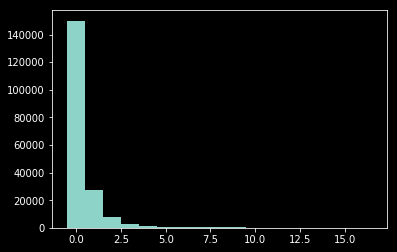

In [33]:
plot_hist(imgid_df['ships'].values, 1)

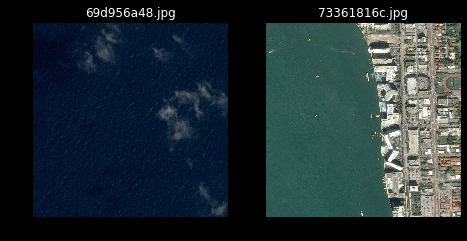

In [34]:
def plot_imgs(img_paths):
    nrows = math.ceil(len(img_paths) / 4)
    f = plt.figure(figsize=(16, 4 * nrows))
    f.tight_layout()
    
    for i, fpath in enumerate(img_paths):
        img = PIL.Image.open(path/'train'/fpath)
        
        sp = f.add_subplot(nrows, 4, i+1)
        sp.axis('off')
        sp.set_title(fpath)
        plt.imshow(img)
        
# Images with minimum and maximum ships
_min, _max = imgid_df['ships'].min(), imgid_df['ships'].max()
fpath_min = imgid_df[imgid_df['ships'] == _min].sample().index[0]
fpath_max = imgid_df[imgid_df['ships'] == _max].sample().index[0]

plot_imgs([fpath_min, fpath_max])

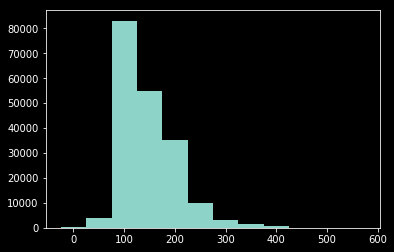

In [35]:
plot_hist(imgid_df['file_size_kb'], 50)

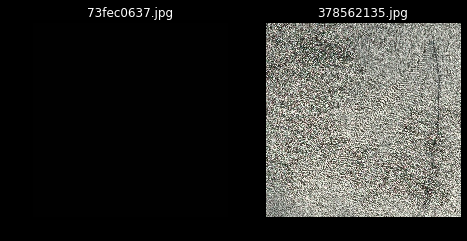

In [36]:
# Outliers in size
_min, _max = imgid_df['file_size_kb'].min(), imgid_df['file_size_kb'].max()
fpath_min = imgid_df[imgid_df['file_size_kb'] == _min].sample().index[0]
fpath_max = imgid_df[imgid_df['file_size_kb'] == _max].sample().index[0]

plot_imgs([fpath_min, fpath_max])

In [37]:
# Only images with 100 <= size <= 300
imgid_df['clean'] = True
query = (imgid_df['file_size_kb'] < 100) | (imgid_df['file_size_kb'] > 300)
imgid_df.loc[query, 'clean'] = False
len(imgid_df[imgid_df['clean']].index)

162097

In [38]:
# Find corrupted images and masks
from tqdm import tqdm

def find_corrupted():
    corrupted = []
    img_ids = imgid_df[imgid_df['clean']].index
    for i in tqdm(range(len(img_ids))):
        img_id = img_ids[i]
        try:
            # Test image
            Image.open(path/'train_v2'/img_id)
            # Test masks
            if imgid_df.loc[img_id, 'ships'] > 0:
                masks = masks_df[masks_df['ImageId'] == img_id]['EncodedPixels']
                for mask in masks:
                    if isinstance(mask, str):
                        vision.rle_decode(mask, (768, 768))
        except:
            corrupted.append(img_id)
    return corrupted
        
#find_corrupted()

In [39]:
# Filter out corrupted images, images without ships and outliers to reclaim disk space
exclude_set = ['6384c3e78.jpg','13703f040.jpg', '14715c06d.jpg',  '33e0ff2d5.jpg',
               '4d4e09f2a.jpg', '877691df8.jpg', '8b909bb20.jpg', 'a8d99130e.jpg', 
               'ad55c3143.jpg', 'c8260c541.jpg', 'd6c7f17c7.jpg', 'dc3e7c901.jpg',
               'e44dffe88.jpg', 'ef87bad36.jpg', 'f083256d8.jpg', 'e27eda89e.jpg', 
               '3c1ed3950.jpg']

query = (imgid_df.index.isin(exclude_set))
imgid_df.loc[query, 'clean'] = False
len(imgid_df[imgid_df['clean']].index)

162095

In [40]:
# Clean masks
clean_imgids = imgid_df[imgid_df['clean']].index
masks_df = masks_df[masks_df['ImageId'].isin(clean_imgids)]

### Run-length encode/decode

In [41]:
# ref: https://www.kaggle.com/paulorzp/run-length-encode-and-decode
from skimage.morphology import label

img_shape = (768, 768)

def rle_encode(img):
    pixels = img.T.flatten()
    pixels = np.concatenate([[0], pixels, [0]])
    runs = np.where(pixels[1:] != pixels[:-1])[0] + 1
    runs[1::2] -= runs[::2]
    return ' '.join(str(x) for x in runs)

def multi_rle_encode(img):
    labels = label(img[:, :, 0])
    return [rle_encode(labels==k) for k in np.unique(labels[labels>0])]

def rle_decode(mask_rle):
    s = mask_rle.split()
    starts, lengths = [np.asarray(x, dtype=int) for x in (s[0:][::2], s[1:][::2])]
    starts -= 1
    ends = starts + lengths
    img = np.zeros(img_shape[0]*img_shape[1], dtype=np.uint8)
    for lo, hi in zip(starts, ends):
        img[lo:hi] = 1
    return img.reshape(img_shape).T  # Needed to align to RLE direction

def multi_rle_decode(masks):
    # Decode ship masks and overlay them into one numpy array
    mask_img = np.zeros(img_shape, dtype=np.uint8)
    for mask in masks:
        if isinstance(mask, str):
            mask_img += rle_decode(mask)
    return np.expand_dims(mask_img, -1)

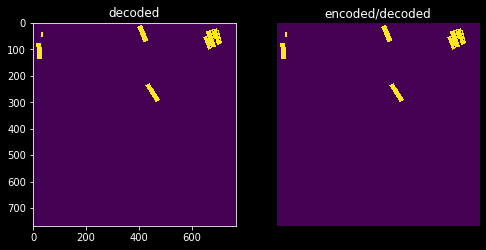

In [43]:
# Check that encode/decode works
def check_encode_decode():
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize = (8, 4))
    
    img_id = masks_df['ImageId'].sample().iloc[0]
    rle_0 = masks_df[masks_df['ImageId'] == img_id]['EncodedPixels']
    img_0 = multi_rle_decode(rle_0)
    ax1.imshow(img_0[:, :, 0])
    ax1.set_title('decoded')
    
    rle_1 = multi_rle_encode(img_0)
    img_1 = multi_rle_decode(rle_1)
    ax2.imshow(img_0[:, :, 0])
    ax2.set_title('encoded/decoded')
    
    plt.axis('off')
    plt.show()
    
check_encode_decode()

### Setting up data loaders

In [44]:
# Custom ImageItemList: Open mask from masks_df, not from disk
def mask_image_to_segment(mask_img):
    mask_tensor = FloatTensor(mask_img)
    mask_tensor = mask_tensor.view(img_shape[1], img_shape[0], -1)
    return vision.ImageSegment(mask_tensor.permute(2,0,1))

def open_mask(fn):
    img_id = fn.stem + fn.suffix
    masks = masks_df[masks_df['ImageId'] == img_id]['EncodedPixels']
    mask_img = multi_rle_decode(masks)
    mask_img = mask_image_to_segment(mask_img)
    return mask_img

class SegmentationLabelList(vision.ImageItemList):
    _processor=vision.data.SegmentationProcessor
    def __init__(self, items:Iterator, classes:Collection=None, **kwargs):
        super().__init__(items, **kwargs)
        self.copy_new.append('classes')
        self.classes, self.loss_func = classes, layers.CrossEntropyFlat(axis=1)

    def open(self, fn): return open_mask(fn)
    def analyze_pred(self, pred, thresh:float=0.5): return pred.argmax(dim=0)[None]
    def reconstruct(self, t:Tensor): return vision.ImageSegment(t)

class SegmentationItemList(vision.ImageItemList):
    "`ItemList` suitable for segmentation tasks."
    _label_cls,_square_show_res = SegmentationLabelList, False

In [56]:
def get_data(bs=16, img_size=(256, 256)):
    # Do not augment since we have a large dataset anyway, only resize
    tfms = ([vision.transform.crop_pad()], [vision.transform.crop_pad()])
    
    # Segmentation task only on images with ships
    with_ships_imgids = imgid_df[imgid_df['ships'] > 0].index
    def filter_func(x):
        img_id = x.stem + x.suffix
        return img_id in clean_imgids and img_id in with_ships_imgids
    
    return (SegmentationItemList.from_folder(path/'train')
            .filter_by_func(filter_func)
            .random_split_by_pct(0.2)
            .label_from_func(lambda x: x, classes=[0, 1])
            .transform(tfms, size=img_size, tfm_y=True)
            .databunch(path=path, bs=bs)
            .normalize(vision.imagenet_stats))

data = get_data(bs=28)
data

ImageDataBunch;

Train: LabelList (26628 items)
x: SegmentationItemList
Image (3, 256, 256),Image (3, 256, 256),Image (3, 256, 256),Image (3, 256, 256),Image (3, 256, 256)
y: SegmentationLabelList
ImageSegment (1, 256, 256),ImageSegment (1, 256, 256),ImageSegment (1, 256, 256),ImageSegment (1, 256, 256),ImageSegment (1, 256, 256)
Path: /home/jupyter/.fastai/data/competitions/airbus-ship-detection/train;

Valid: LabelList (6657 items)
x: SegmentationItemList
Image (3, 256, 256),Image (3, 256, 256),Image (3, 256, 256),Image (3, 256, 256),Image (3, 256, 256)
y: SegmentationLabelList
ImageSegment (1, 256, 256),ImageSegment (1, 256, 256),ImageSegment (1, 256, 256),ImageSegment (1, 256, 256),ImageSegment (1, 256, 256)
Path: /home/jupyter/.fastai/data/competitions/airbus-ship-detection/train;

Test: None

(256, 256, 3)


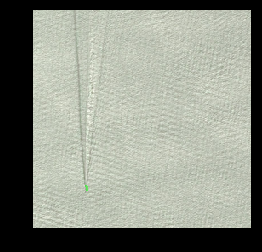

In [46]:
# Make sure transformations work
import cv2

def mask_overlay(image, mask, color=(0, 1, 0)):
    mask = np.dstack((mask, mask, mask)) * np.array(color)
    mask = mask.astype(image.dtype)
    weighted_sum = cv2.addWeighted(mask, 0.5, image, 0.5, 0.)
    img = image.copy()
    ind = mask[:, :, np.argmax(color)] > 0
    img[ind] = weighted_sum[ind]    
    return img

def imshow(idx=None):
    if idx is None:
        idx = random.choice(range(len(data.train_ds)))
        
    img = data.train_ds[idx][0]
    img = img.data.permute(1, 2, 0).numpy()
    mask_img = data.train_ds[idx][1]
    mask_img = mask_img.data.permute(1, 2, 0).numpy()
    overlayed = mask_overlay(img, mask_img)
    print(overlayed.shape)
    
    plt.imshow(overlayed)
    plt.axis('off')
    plt.show()
    
imshow()

## Image segmentation

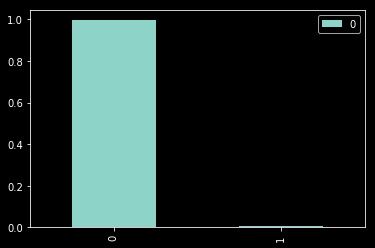

In [47]:
# Measure class imbalance by counting pixels
def plot_pixel_counts(num_samples=100):
    num_imgs = len(data.train_ds)
    counts = np.zeros((num_imgs, data.c))
    random_idxs = random.sample(range(num_imgs), num_samples)
    
    for idx in random_idxs:
        mask_tensor = data.train_ds[idx][1].data
        for c in range(data.c):
            counts[idx, c] = (mask_tensor == c).sum()
    
    rel_counts = counts.sum(axis=0)/counts.sum()
    df = pd.DataFrame(rel_counts, index=data.classes)
    df.plot.bar()
    plt.show()
    
plot_pixel_counts()

In [48]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable

# https://becominghuman.ai/investigating-focal-and-dice-loss-for-the-kaggle-2018-data-science-bowl-65fb9af4f36c
def cuda(x): 
    return x.cuda() if torch.cuda.is_available() else x

def make_one_hot(labels, c=2):
    one_hot = cuda(torch.FloatTensor(labels.size(0), c, labels.size(2), labels.size(3)).zero_())
    target = one_hot.scatter_(1, labels.data, 1)
    target = cuda(Variable(target))
    return target

def dice_loss(input, target):
    # Input is of shape N,C,H,W
    smooth = 1
    batch_size = input.size(0)
    input = F.softmax(input, dim=1)
    # Since we have only 2 classes transform it to N,H,W and treat as sigmoid
    input = input.view(batch_size, 2, -1)[:, 1, :]
    target = make_one_hot(target).view(batch_size, 2, -1)[:, 1, :]

    inter = torch.sum(input * target) + smooth
    union = torch.sum(input) + torch.sum(target) + smooth

    return -torch.log(2.0 * inter / union)

class FocalLoss(nn.Module):
    # This loss function demonstrates amazing results on datasets with unbalance level 1:10-1000
    def __init__(self, gamma):
        super(FocalLoss, self).__init__()
        self.gamma = gamma

    def forward(self, input, target):
        # One-hot encode target
        target = target.squeeze(1)
    
        input = input.view(input.size(0),input.size(1),-1) # N,C,H,W => N,C,H*W
        input = input.transpose(1,2)                       # N,C,H*W => N,H*W,C
        input = input.contiguous().view(-1,input.size(2))  # N,H*W,C => N*H*W,C
        target = target.view(-1,1)

        logpt = F.log_softmax(input, dim=1)
        logpt = logpt.gather(1,target)
        logpt = logpt.view(-1)
        pt = Variable(logpt.data.exp())

        loss = -1 * (1-pt)**self.gamma * logpt
        return loss.mean()
    
# https://www.kaggle.com/iafoss/unet34-dice-0-87
class MixedLoss(nn.Module):
    def __init__(self, alpha, gamma):
        super().__init__()
        self.alpha = alpha
        self.focal = FocalLoss(gamma)
        
    def forward(self, input, target):
        return self.alpha * self.focal(input, target) + dice_loss(input, target)

loss_func = MixedLoss(10., 2.)

In [49]:
def dice(input, target):
    input = input.argmax(dim=1).float()
    target = target.squeeze(1).float()
    
    smooth = 1.
    numerator = 2. * (input * target).sum()
    denumerator = (input + target).sum()
    return (numerator + smooth) / (denumerator + smooth)

def IoU(input, target):
    input = input.argmax(dim=1).float()
    target = target.squeeze(1).float()
    
    smooth = 1.
    intersection = (input * target).sum()
    union = (input + target).sum() - intersection
    return (intersection + smooth) / (union + smooth)

metrics = [dice, IoU]

In [62]:
# Put learn in FP16 precision mode
learn = vision.unet_learner(data, vision.models.resnet34, metrics=metrics, loss_func=loss_func, wd=1e-2).to_fp16()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.
Min numerical gradient: 1.45E-05


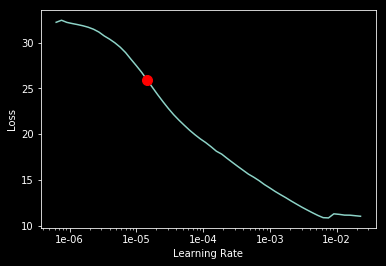

In [71]:
learn.lr_find()
learn.recorder.plot()

In [72]:
learn.fit_one_cycle(5, slice(1e-03), pct_start=0.9)

epoch,train_loss,valid_loss,dice,IoU
1,0.359922,0.344204,0.790130,0.655252
2,0.258811,0.271773,0.823152,0.701677
3,0.226246,0.237825,0.846243,0.735197
4,0.215694,0.233588,0.846426,0.735851
5,0.155314,0.162106,0.890195,0.803043


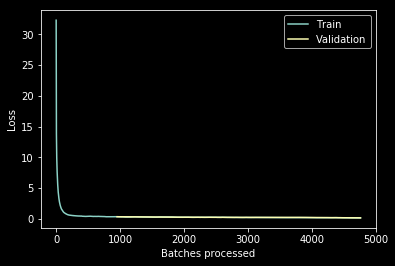

In [73]:
learn.recorder.plot_losses()

In [74]:
learn.save('Unet34_256_1')

In [63]:
learn.load('Unet34_256_1');

In [64]:
learn.unfreeze()

In [72]:
# Decrease batch size after unfreezing
learn.data = get_data(bs=24)

In [74]:
learn.model.float();

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.
Min numerical gradient: 1.32E-06


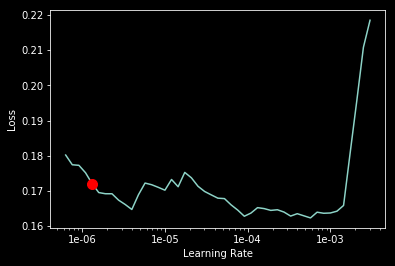

In [75]:
learn.lr_find()
learn.recorder.plot()

In [76]:
learn.fit_one_cycle(5, slice(1e-06, 1e-04))

epoch,train_loss,valid_loss,dice,IoU
1,0.148240,0.136167,0.906844,0.830266
2,0.130744,0.128493,0.911900,0.838788
3,0.122117,0.122579,0.915629,0.844962
4,0.114697,0.118946,0.918052,0.849085
5,0.111336,0.118361,0.918596,0.850029


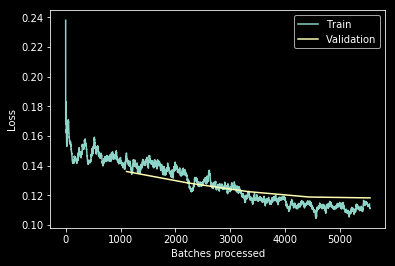

In [77]:
learn.recorder.plot_losses()

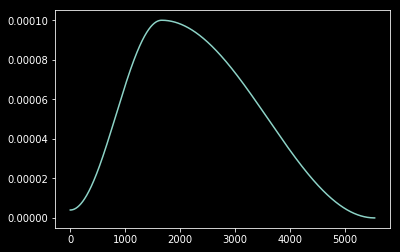

In [78]:
learn.recorder.plot_lr()

In [79]:
learn.save('Unet34_256_2')

In [41]:
# We only train with 256-sized images since their quality doesn't get any better with their size.

### Model evaluation

In [80]:
data = get_data(bs=1)

In [81]:
learn = vision.unet_learner(data, vision.models.resnet34, metrics=metrics, loss_func=loss_func)

In [82]:
learn.load('Unet34_256_2');

In [83]:
outputs, targets = learn.get_preds(vision.DatasetType.Valid)

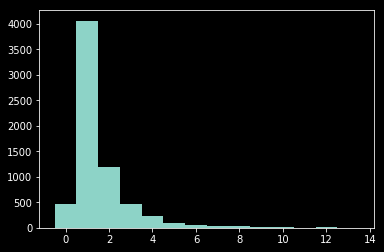

In [84]:
def count_ships(outputs):
    ship_counts = []
    for idx, output in enumerate(outputs):
        probs = F.softmax(output, dim=0)
        mask_tensor = probs.argmax(dim=0)
        mask_tensor = mask_tensor.unsqueeze(2)
        masks = multi_rle_encode(mask_tensor)
        ship_counts.append(len(masks))
    return np.array(ship_counts)

ship_counts = count_ships(outputs)
plot_hist(ship_counts, 1)

torch.Size([3, 256, 256]) torch.Size([1, 256, 256]) torch.Size([1, 256, 256])


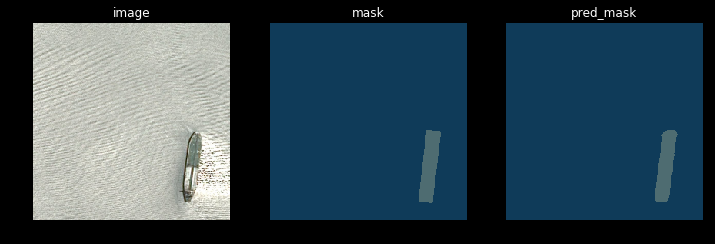

In [85]:
# Make sure decode works
def imshow_valid():
    idx = random.choice(range(len(data.valid_ds)))
    
    fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(12, 4))
    img = learn.data.valid_ds[idx][0]
    mask = learn.data.valid_ds[idx][1]
    img.show(ax=ax1)
    ax1.set_title('image')
    mask.show(ax=ax2)
    ax2.set_title('mask')
    print(img.shape, mask.shape, learn.predict(img)[0].shape)
    learn.predict(learn.data.valid_ds[idx][0])[0].show(ax=ax3)
    ax3.set_title('pred_mask')
    
    plt.axis('off')
    plt.show()
    
imshow_valid()

## Binary classification

In [87]:
# How balanced is the dataset?
wo_ships_query = imgid_df['clean'] & (imgid_df['ships'] == 0)
w_ships_query = imgid_df['clean'] & (imgid_df['ships'] > 0)
imgid_wo_ships = set(imgid_df[wo_ships_query].index)
imgid_w_ships = set(imgid_df[w_ships_query].index)

len(imgid_wo_ships), len(imgid_w_ships)

(128810, 33285)

In [88]:
# Downsample image without ships
cl_imgids = set(random.sample(imgid_wo_ships, len(imgid_w_ships))) | imgid_w_ships

len(cl_imgids)

66570

In [89]:
def get_cl_data(bs=64, img_size=(256, 256)):
    tfms = vision.get_transforms(flip_vert=True, max_zoom=1., max_warp=None, max_lighting=None)
    return (vision.ImageItemList.from_folder(path/'train')
            .filter_by_func(lambda x: (x.stem + x.suffix) in cl_imgids)
            .random_split_by_pct(0.2)
            .label_from_func(lambda x: (x.stem + x.suffix) in imgid_w_ships)
            .transform(tfms, size=img_size)
            .databunch(path=path, bs=bs)
            .normalize(vision.imagenet_stats))

cl_data = get_cl_data()
cl_data

ImageDataBunch;

Train: LabelList (53256 items)
x: ImageItemList
Image (3, 256, 256),Image (3, 256, 256),Image (3, 256, 256),Image (3, 256, 256),Image (3, 256, 256)
y: CategoryList
False,True,False,True,True
Path: /home/jupyter/.fastai/data/competitions/airbus-ship-detection/train;

Valid: LabelList (13314 items)
x: ImageItemList
Image (3, 256, 256),Image (3, 256, 256),Image (3, 256, 256),Image (3, 256, 256),Image (3, 256, 256)
y: CategoryList
False,False,False,False,True
Path: /home/jupyter/.fastai/data/competitions/airbus-ship-detection/train;

Test: None

In [90]:
cl_learn = vision.create_cnn(cl_data, vision.models.resnet34, metrics=metrics.accuracy)

AttributeError: 'list' object has no attribute 'accuracy'

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


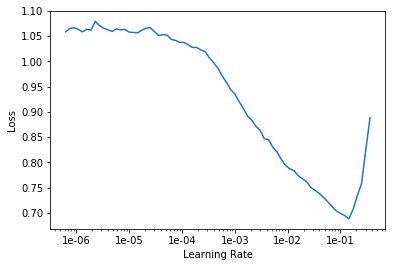

In [24]:
cl_learn.lr_find()
cl_learn.recorder.plot()

In [25]:
cl_learn.fit_one_cycle(5, slice(1e-2))

epoch,train_loss,valid_loss,accuracy
1,0.237676,0.139811,0.946598
2,0.192989,0.126411,0.952606
3,0.157286,0.111658,0.959066
4,0.130949,0.087380,0.968229
5,0.130832,0.089485,0.967027


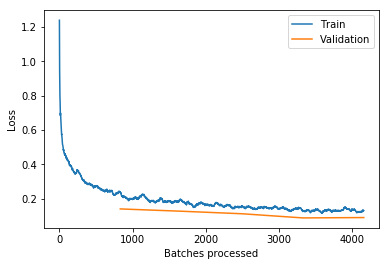

In [31]:
cl_learn.recorder.plot_losses()

In [34]:
cl_learn.save('Resnet34_256_1')

In [24]:
cl_learn.load('Resnet34_256_1');

In [25]:
cl_learn.unfreeze()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


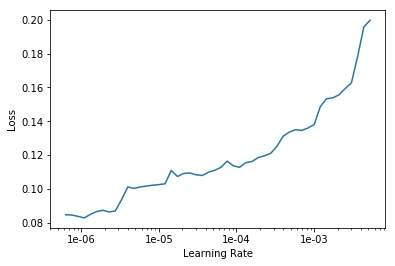

In [26]:
cl_learn.lr_find()
cl_learn.recorder.plot()

In [27]:
cl_learn.fit_one_cycle(10, slice(1e-6, 1e-4))

epoch,train_loss,valid_loss,accuracy
1,0.115520,0.087944,0.969731
2,0.113862,0.081118,0.970407
3,0.094870,0.075243,0.973336
4,0.097015,0.073903,0.974538
5,0.083740,0.065513,0.977017
6,0.076560,0.063514,0.978068
7,0.072485,0.063701,0.977993
8,0.069260,0.060580,0.979120
9,0.076709,0.058557,0.978669
10,0.065059,0.057908,0.979345


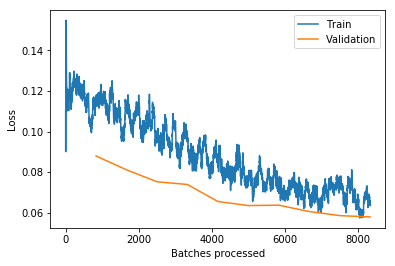

In [28]:
cl_learn.recorder.plot_losses()

In [29]:
cl_learn.save('Resnet34_256_2')

### Model evaluation

In [31]:
cl_data = get_cl_data()

In [32]:
cl_learn = vision.create_cnn(cl_data, vision.models.resnet34, metrics=metrics.accuracy)

In [33]:
cl_learn.load('Resnet34_256_2');

In [52]:
interp = vision.ClassificationInterpretation.from_learner(cl_learn)

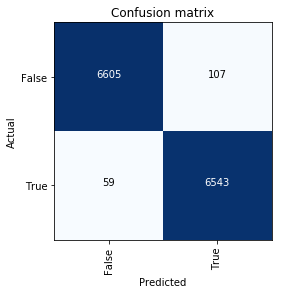

In [60]:
interp.plot_confusion_matrix()

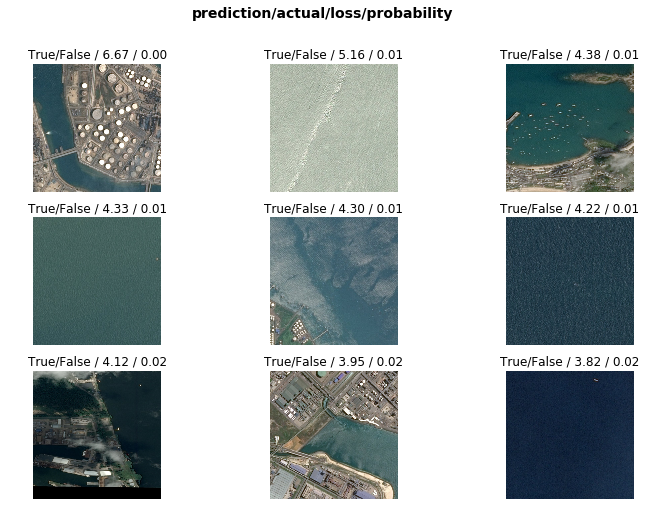

In [59]:
interp.plot_top_losses(9, figsize=(12, 8))

In [62]:
cl_learn.export('Resnet34_256.pkl')

In [ ]:
# Also look at 
# https://towardsdatascience.com/image-segmentation-kaggle-experience-9a41cb8924f0
# https://github.com/kheyer/ML-DL-Projects/tree/master/Airbus%20Ship%20Detection